In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [ ]:
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader

In [ ]:
label_datat=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_test.txt',dtype=int)
label_datat=label_datat.tolist()
data_patht='/home/sumins/workspace/washout classification/min_slice/channel4_test.nii'
channel4t=[]
totalt=nib.load(data_patht).get_fdata()
totalslicet=totalt.shape[0]  

for i in range(0,totalslicet):
    channel4t.append(totalt[i,:,:,:])

In [ ]:
channel4t[0].shape

In [ ]:
WINDOW_MAX = 200
WINDOW_MIN = 0
GLOBAL_PIXEL_MEAN = 0.1

class CustomDataset(Dataset): 
  def __init__(self,volume_list,all_labels,transforms=None):
    self.volume_list=volume_list
    self.all_labels=all_labels
    self.length=len(all_labels)
    self.transforms=transforms


  def __len__(self):
    return self.length


  def __getitem__(self, idx):
    npy=self.volume_list[idx]

    npy[npy > WINDOW_MAX] = WINDOW_MAX
    npy[npy < WINDOW_MIN] = WINDOW_MIN
    
    npy = (npy - WINDOW_MIN) / (WINDOW_MAX - WINDOW_MIN)
    
    
    npy=npy.astype(dtype='float32')
    if self.transforms is not None:
      npy=self.transforms(npy)
    
    return npy

In [ ]:

transforms_test = transforms.Compose([transforms.ToTensor()
                                       ])

In [ ]:
test_dataset=CustomDataset(volume_list=channel4t, all_labels=label_datat,transforms=transforms_test)

In [ ]:
test_dataset[0].shape

In [49]:

class Guided_backprop():
    def __init__(self, model):
        self.model = model
        self.image_reconstruction = None # store R0
        self.activation_maps = []  # store f1, f2, ... 
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        def first_layer_hook_fn(module, grad_in, grad_out):
            self.image_reconstruction = grad_in[0] 

        def forward_hook_fn(module, input, output):
            self.activation_maps.append(output)

        def backward_hook_fn(module, grad_in, grad_out):
            grad = self.activation_maps.pop() 
            # for the forward pass, after the ReLU operation, 
            # if the output value is positive, we set the value to 1,
            # and if the output value is negative, we set it to 0.
            grad[grad > 0] = 1 
            
            # grad_out[0] stores the gradients for each feature map,
            # and we only retain the positive gradients
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)
            new_grad_in = positive_grad_out * grad

            return (new_grad_in,)


        # AlexNet model 
        modules = list(self.model.named_children())


        for name, module in modules:
            k=list(module.named_children())
            if len(k)==2:
                if isinstance(k[0][1][2], nn.LeakyReLU):
                    k[0][1][2].register_forward_hook(forward_hook_fn)
                    k[0][1][2].register_backward_hook(backward_hook_fn)
            if name=='layer1':

                first_layer = k[0][1][0]
                first_layer.register_backward_hook(first_layer_hook_fn)

    def visualize(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        pred_class = model_output.argmax().item()
        print("pred_class: ", pred_class)
        grad_target_map = torch.zeros(model_output.shape,
                                      dtype=torch.float)
        if target_class is not None:
            grad_target_map[0][target_class] = 1
        else:
            grad_target_map[0][pred_class] = 1
        
        model_output.backward(grad_target_map)

        result = self.image_reconstruction.data[0].permute(1,2,0)
        #result=result**2
        return result.numpy()

def normalize(image):
    norm = (image - image.mean())/image.std()
    norm = norm * 0.1
    norm = norm + 0.5
    norm = norm.clip(0, 1)
    return norm

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // r),
            nn.ReLU(),
            nn.Linear(in_channels // r, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1) 
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x
    
class Depthwise(nn.Module):
    def __init__(self, in_num, out_num, stride=1):
        super().__init__()
        
        self.depthwise=nn.Sequential(
            nn.Conv2d(in_num, out_num,3,stride=stride, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.seblock=SEBlock(out_num)
    
    def forward(self,x):
        x=self.depthwise(x)
        x=self.seblock(x)*x
        return x
    
class CustomConvNet(nn.Module):
    def __init__(self):
        super().__init__() #상속받은 class에 접근하기 위함

        self.layer1 = Depthwise(4, 16) #흑백사진은 inp
        self.layer2 = Depthwise(16, 32)
        self.layer3 = Depthwise(32, 64)
        self.layer4 = Depthwise(64, 128)
        self.layer5 = Depthwise(128, 256)
        self.gap = self.global_avg_pool(256, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1, 2)

        return out

    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1)))



In [22]:
model=CustomConvNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

checkpoint = torch.load('/home/sumins/workspace/washout classification/model_save/senet.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [23]:
print('Architecture:\n', '-'*60, '\n', model, '\n', '-'*60)

Architecture:
 ------------------------------------------------------------ 
 CustomConvNet(
  (layer1): Depthwise(
    (depthwise): Sequential(
      (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (seblock): SEBlock(
      (squeeze): AdaptiveAvgPool2d(output_size=(1, 1))
      (excitation): Sequential(
        (0): Linear(in_features=16, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=16, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (layer2): Depthwise(
    (depthwise): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=

pred_class:  0
Label:  0


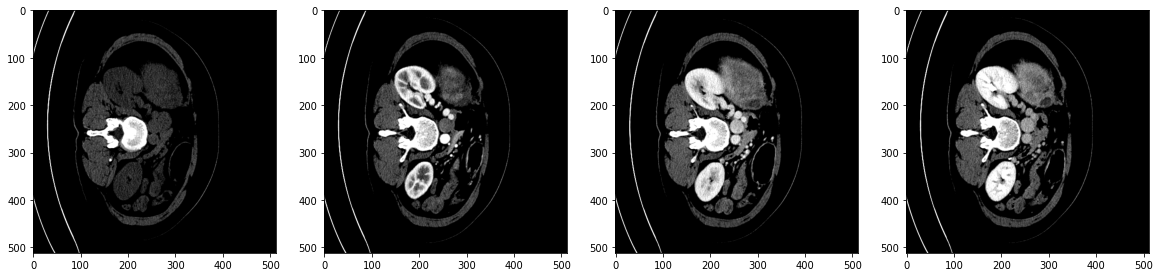

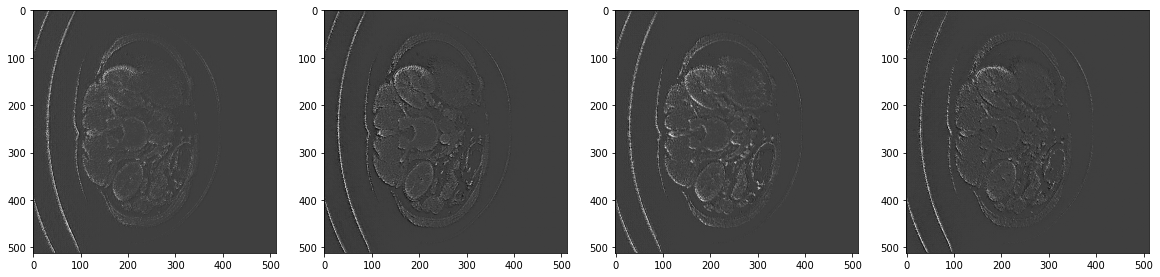

: 

In [63]:
for i in [271]:#, 101, 150, 71, 90 ,271
    tensor = test_dataset[i].unsqueeze(0).requires_grad_()
    guided_bp = Guided_backprop(model)
    result = guided_bp.visualize(tensor, target_class=1)
    #print(test_dataset[0])
    
    result=normalize(result)
    result=result**2
    #print(result)
    print("Label: ",label_datat[i])
    # for i in test_dataset:
    fig=plt.figure(figsize=(20,20))
    rows=1
    cols=4
    q=1
    for j in [1,0,3,2]:
        k=fig.add_subplot(rows,cols,q)
        q+=1
        k.imshow(np.fliplr(test_dataset[i][j,:,:]),cmap='gray')
    plt.show()
        

    fig=plt.figure(figsize=(20,20))
    rows=1
    cols=4
    q=1
    for j in [1,0,3,2]:
        k=fig.add_subplot(rows,cols,q)
        q+=1
        k.imshow(np.fliplr(result[:,:,j]),cmap='gray')
    plt.show()

pred_class:  1
Label:  1


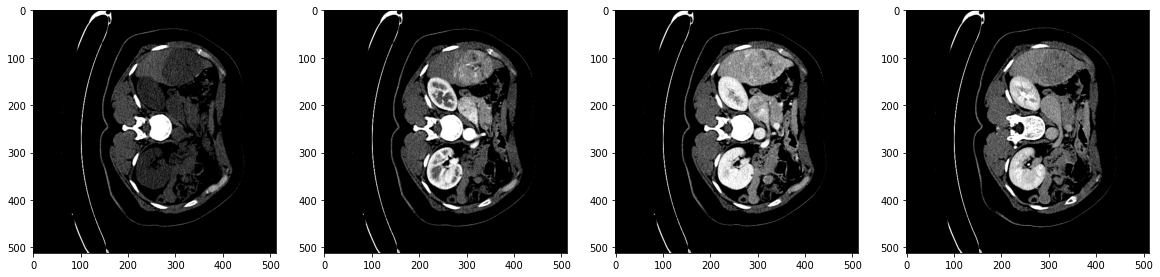

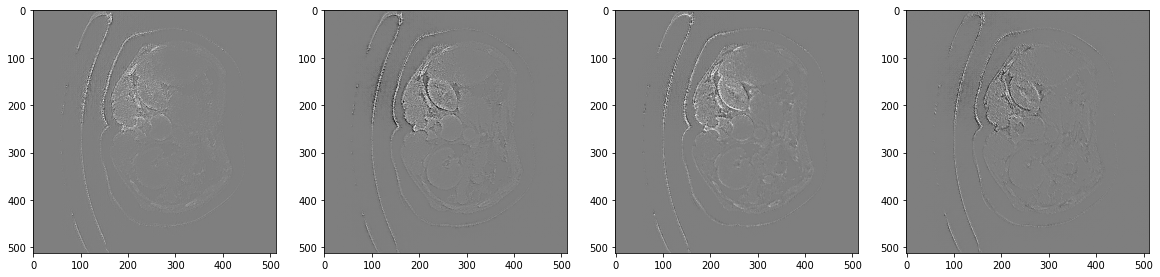

In [58]:
for i in [101]:#, 101, 150, 71, 90 ,271
    tensor = test_dataset[i].unsqueeze(0).requires_grad_()
    guided_bp = Guided_backprop(model)
    result = guided_bp.visualize(tensor, target_class=0)
    #print(test_dataset[0])    
    #result=result**2
    result=normalize(result)

    print("Label: ",label_datat[i])
    # for i in test_dataset:
    fig=plt.figure(figsize=(20,20))
    rows=1
    cols=4
    q=1
    for j in [1,0,3,2]:
        k=fig.add_subplot(rows,cols,q)
        q+=1
        k.imshow(np.fliplr(test_dataset[i][j,:,:]),cmap='gray')
    plt.show()
        

    fig=plt.figure(figsize=(20,20))
    rows=1
    cols=4
    q=1
    for j in [1,0,3,2]:
        k=fig.add_subplot(rows,cols,q)
        q+=1
        k.imshow(np.fliplr(result[:,:,j]),cmap='gray')
    plt.show()